# Esperienza 2 - campionamento

**Importazione librerie**

In [45]:
%matplotlib inline
import pandas as pd
import scipy
from scipy.stats import trim_mean
import statsmodels
from statsmodels import robust
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import astropy
import IPython
import math
import matplotlib
import emcee
import corner

**Codice lettura dati**

In [2]:
# wavio.py
# Author: Warren Weckesser
# License: BSD 3-Clause (http://opensource.org/licenses/BSD-3-Clause)

import wave as _wave
import numpy as _np


def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = _np.empty((num_samples, nchannels, 4), dtype=_np.uint8)
        raw_bytes = _np.frombuffer(data, dtype=_np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = _np.frombuffer(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result


def readwav(file):
    """
    Read a WAV file.

    Parameters
    ----------
    file : string or file object
        Either the name of a file or an open file pointer.

    Return Values
    -------------
    rate : float
        The sampling frequency (i.e. frame rate)
    sampwidth : float
        The sample width, in bytes.  E.g. for a 24 bit WAV file,
        sampwidth is 3.
    data : numpy array
        The array containing the data.  The shape of the array is
        (num_samples, num_channels).  num_channels is the number of
        audio channels (1 for mono, 2 for stereo).

    Notes
    -----
    This function uses the `wave` module of the Python standard libary
    to read the WAV file, so it has the same limitations as that library.
    In particular, the function does not read compressed WAV files.

    """
    wav = _wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, array


def writewav24(filename, rate, data):
    """
    Create a 24 bit wav file.

    Parameters
    ----------
    filename : string
        Name of the file to create.
    rate : float
        The sampling frequency (i.e. frame rate) of the data.
    data : array-like collection of integer or floating point values
        data must be "array-like", either 1- or 2-dimensional.  If it
        is 2-d, the rows are the frames (i.e. samples) and the columns
        are the channels.

    Notes
    -----
    The data is assumed to be signed, and the values are assumed to be
    within the range of a 24 bit integer.  Floating point values are
    converted to integers.  The data is not rescaled or normalized before
    writing it to the file.

    Example
    -------
    Create a 3 second 440 Hz sine wave.

    >>> rate = 22050  # samples per second
    >>> T = 3         # sample duration (seconds)
    >>> f = 440.0     # sound frequency (Hz)
    >>> t = np.linspace(0, T, T*rate, endpoint=False)
    >>> x = (2**23 - 1) * np.sin(2 * np.pi * f * t)
    >>> writewav24("sine24.wav", rate, x)

    """
    a32 = _np.asarray(data, dtype=_np.int32)
    if a32.ndim == 1:
        # Convert to a 2D array with a single column.
        a32.shape = a32.shape + (1,)
    # By shifting first 0 bits, then 8, then 16, the resulting output
    # is 24 bit little-endian.
    a8 = (a32.reshape(a32.shape + (1,)) >> _np.array([0, 8, 16])) & 255
    wavdata = a8.astype(_np.uint8).tostring()

    w = _wave.open(filename, 'wb')
    w.setnchannels(a32.shape[1])
    w.setsampwidth(3)
    w.setframerate(rate)
    w.writeframes(wavdata)
    w.close()

**Fisso le dimensioni delle informazioni dei plot**

In [3]:
#Fisso le dimensioni delle label e delle informazioni dei plot
plt.rcParams.update({"font.size":15})
plt.rcParams.update({"ytick.direction":"inout"})
plt.rcParams.update({"xtick.direction":"inout"})
plt.rcParams.update({"xtick.major.size":6.5})
plt.rcParams.update({"ytick.major.size":6.5})

## Inizio codifica vera e propria

### 1. Ricavare lo spettro di potenza

In [4]:
import scipy.fft as fft
import pathlib

In [5]:
folderpath = pathlib.Path("/home/elisa/Desktop/Uni/ModelDati/Esperienza2/Organ")

In [6]:
paths = ["/home/elisa/Desktop/Uni/ModelDati/Esperienza2/Organ/note_" + str(i) + ".wav" for i in(range(1,280))]

In [7]:
readwav(paths[3])

(48000,
 array([[      0,       0],
        [      0,       0],
        [      0,       0],
        ...,
        [-152251,   29482],
        [-180320,   33399],
        [-192157,   32451]], dtype=int32))

In [8]:
rate, data = readwav(paths[0])

IPython.display.Audio(data[:,1], rate=rate)

**Gaussare il suono**

Per ricavare lo spettro di potenza del suono devo fare la trasformata di Fourier della nota, non posso fare la trasformata di fourier sulla registrazione originale perchè il suono è tagliato, questo taglio viene letto dalla trasformata come una frequenza aggiuntiva che quindi sporca la mia analisi dati. Devo pertanto modulare il suono con una gaussiana in maniera tale che vada a zero in maniera smooth all'interno dell'intervalo di campionamento. 

Prima di iterare il processo su tutte le registrazioni che ho a disposizione lo eseguo su una nota sola.
In particolare voglio moltiplicare per una gaussiana centrata sul centro dell'intervallo e con una sigma t.c. nell'intervallo ci stiano 3sigma più o meno

In [9]:
rate, audio = readwav(paths[0])

In [26]:
print(readwav(paths[0])[1])

[[      0       0]
 [      0       0]
 [      0       0]
 ...
 [-152251   29482]
 [-180320   33399]
 [-192157   32451]]


In [27]:
print(len(readwav(paths[0])[1]))

360071


In [28]:
print(readwav(paths[0])[1][0])

[0 0]


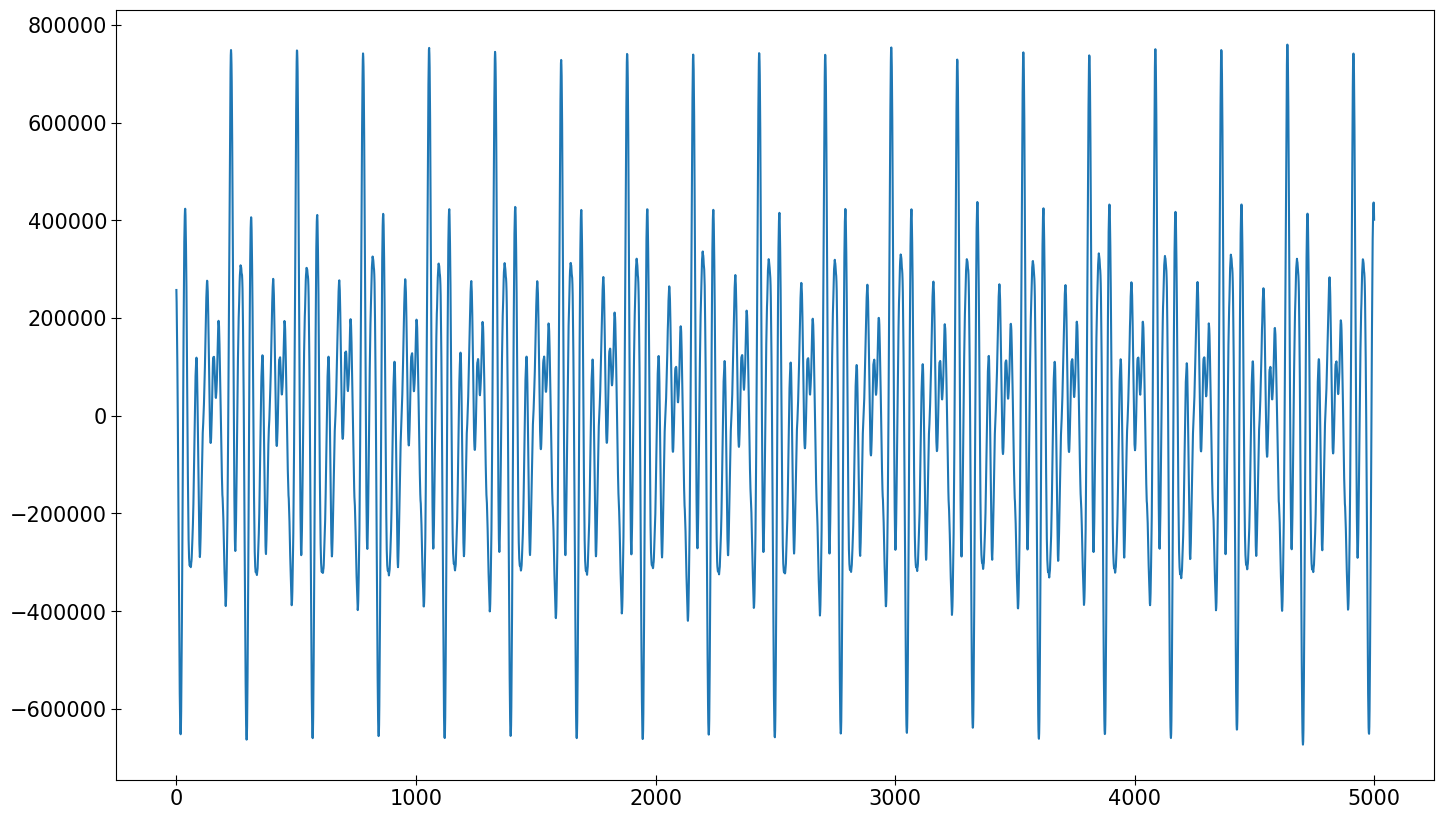

In [17]:
audio = readwav(paths[0])[1]

plt.figure(figsize = (17, 10))
plt.plot(audio[rate:rate+5000,0]) #questo può essere un intervallo di punti carino su cui lavorare

5000


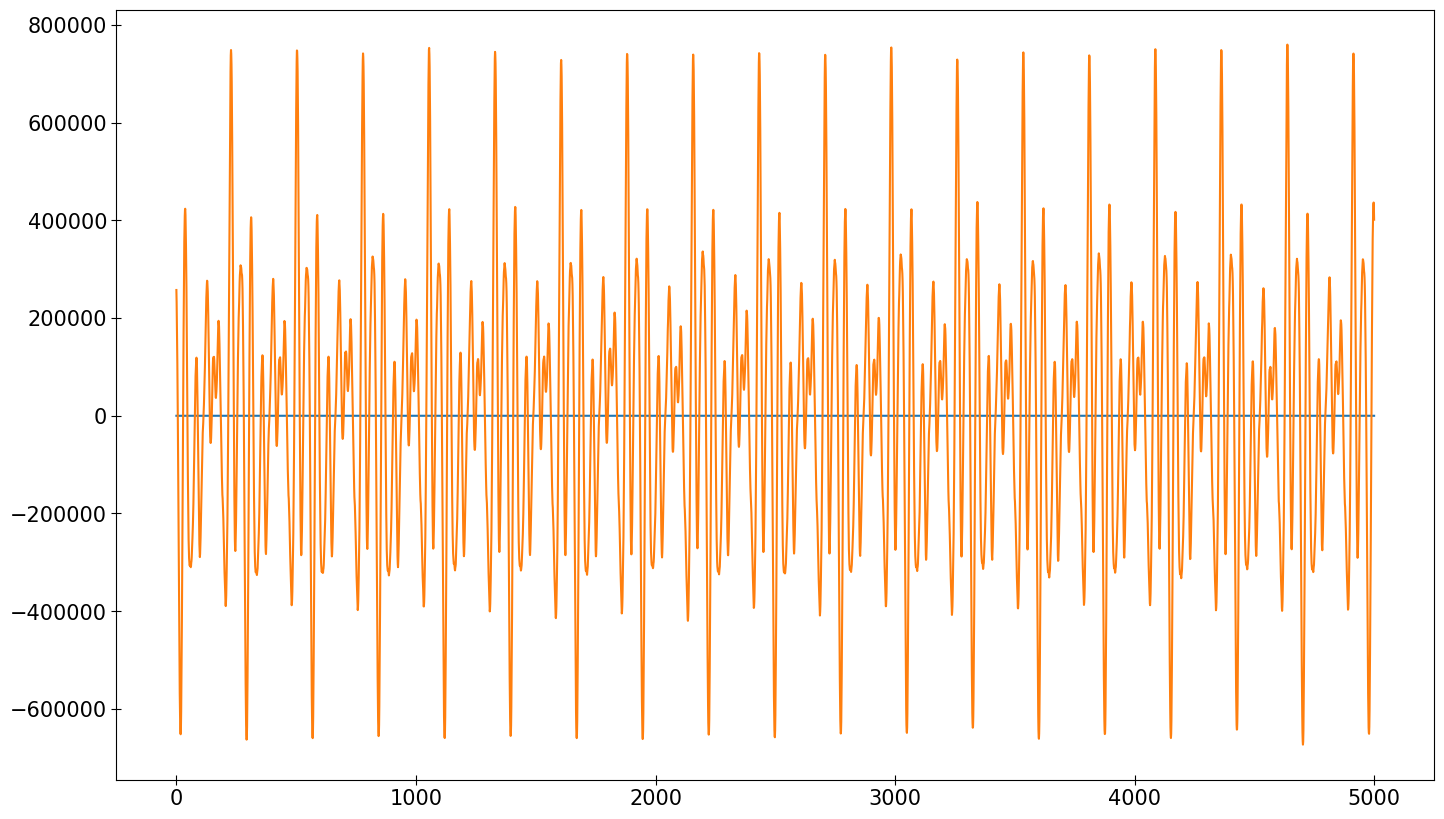

In [28]:
t = np.linspace(0,5000,5000)

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

gauss = gaussian(t,2500,1000)
print(len(gauss))

module = audio[rate:rate+5000,0]#*gauss
plt.figure(figsize = (17, 10))
plt.plot(gauss)
plt.plot(module)

* Cercare di cpaire come scegliere la modulazione: se la scelgo troppo bassa cambio l'ampiezza del segnalre e erischio di cambiare troppo anche la sua frequenza.
* capire come scegliere mu, sigma in funzione dell'intervallo, dell'ampiezza del segnale e della sua frequenza

**Trasformata di Fourier e spettro di potenza**

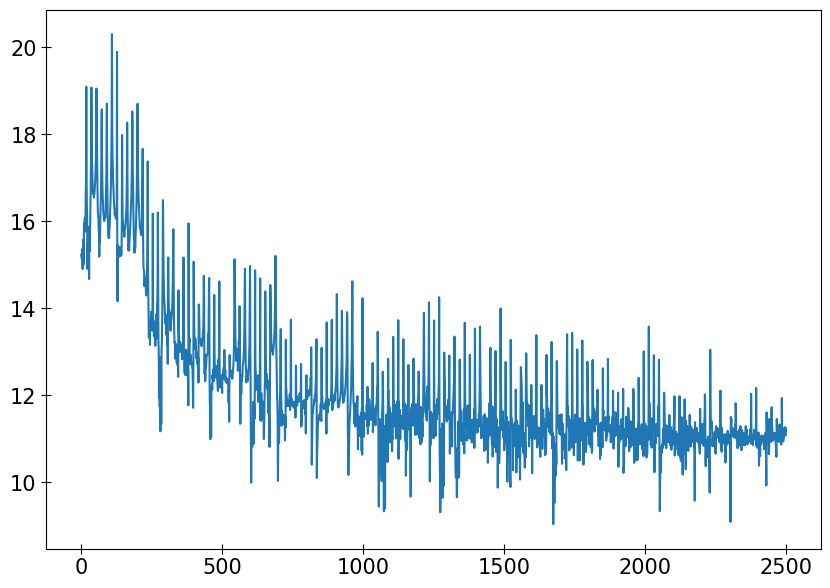

In [52]:
fft = scipy.fft.rfft(module)

Y = [abs(fft[i])**2 for i in range(len(fft))]
plt.figure(figsize = (10, 7))
plt.plot(np.log(fft))
#plt.plot(Y)

[   3    7   10   13   18   23   26   29   36   43   54   65   73   84
   91   98  109  120  127  130  133  135  139  141  145  151  154  163
  169  181  190  200  209  218  227  236  241  243  245  248  251  254
  257  259  262  264  267  272  277  280  282  290  299  304  306  309
  312  314  318  327  332  336  338  340  343  345  349  351  353  357
  363  368  370  372  374  378  381  384  389  391  394  399  405  410
  413  415  417  422  426  428  435  439  442  446  450  454  459  464
  466  468  472  475  478  480  482  487  490  496  499  501  505  508
  511  515  518  521  524  527  530  533  535  537  544  552  557  559
  562  567  569  581  588  599  606  608  611  613  617  621  623  627
  629  635  637  639  641  644  646  653  657  659  661  665  671  679
  689  700  708  712  714  717  719  721  724  726  730  733  740  744
  746  750  753  756  759  762  764  768  770  773  775  780  783  785
  787  789  792  795  799  801  804  808  814  816  821  827  829  835
  840 

ValueError: 'fft' is not a valid format string (unrecognized character 'f')

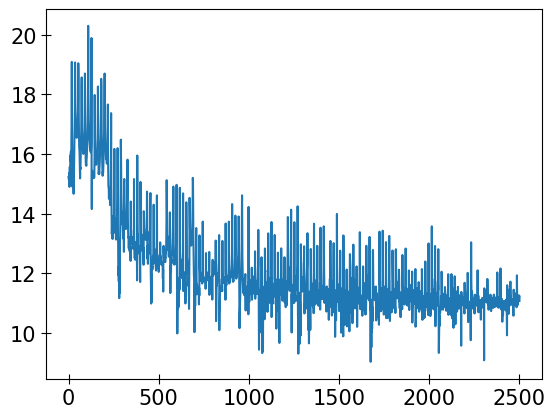

In [42]:
peaks = scipy.signal.find_peaks(np.log(fft))
print(peaks[0])

plt.plot(np.log(fft))

peaks, _ = scipy.signal.find_peaks(np.log(fft), height=0)
plt.plot(np.log(fft))
plt.plot(peaks, npfft[peaks], "fft")

#plt.plot(peaks)
#plt.plot(np.zeros_like(x), "--", color="gray")
#plt.show()

**Metodo alternativo per lettura .wav**

<ipython-input-49-14c66f0a28ab>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  input_data = read(paths[3])


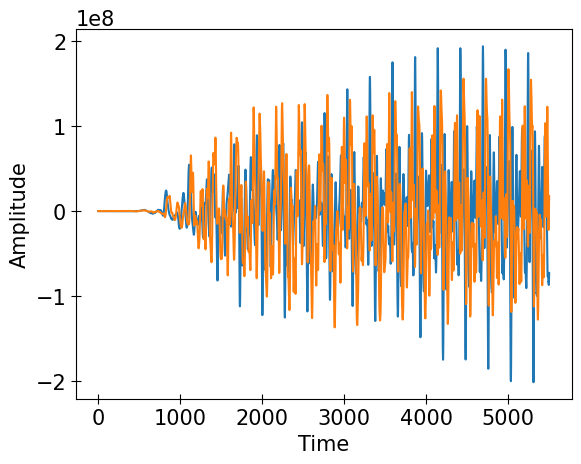

In [49]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
input_data = read(paths[3])
audio = input_data[1]
plt.plot(audio[0:5500])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()